In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K



df = pd.read_csv("FourRegionData.csv")
df.head(10)


,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,2,2001,1,17.40,18.81,19.43,0,18.38,13.04,25.44,62.68,7.94,2.17,101268.29,199.25
1,2,2001,2,19.88,19.98,20.36,1,22.61,16.90,28.56,61.71,7.19,1.98,101039.08,210.73
2,2,2001,3,24.08,23.32,23.17,33,26.62,20.73,31.84,55.48,8.75,2.10,100882.56,251.75
3,2,2001,4,27.62,27.02,26.77,46,29.06,24.71,32.06,65.63,8.55,2.70,100655.40,257.46
4,2,2001,5,28.54,28.29,28.21,402,27.69,24.18,32.09,77.39,6.10,2.37,100234.63,172.32
5,2,2001,6,30.11,29.82,29.64,386,28.03,25.55,31.75,83.17,3.51,3.64,99934.18,140.45
6,2,2001,7,30.74,30.53,30.64,202,28.83,25.92,31.60,80.26,4.55,3.87,99991.05,169.40
7,2,2001,8,30.99,30.99,30.86,205,29.46,25.23,31.50,82.19,5.15,3.01,100129.68,181.66
8,2,2001,9,29.83,29.89,29.95,209,28.71,24.34,32.42,82.53,4.65,2.14,100499.17,170.22
9,2,2001,10,28.00,28.29,28.50,177,27.63,22.83,31.44,80.45,5.60,1.59,100864.38,167.89


In [13]:
# Feature and target selection
features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature', 'Surface Pressure']]
target = df['SoilTemperature-50']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1))


def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

WINDOW = 3
X_seq, y_seq = create_sliding_window(X_scaled, y_scaled, WINDOW)

total_samples = len(X_seq)
train_end = int(0.7 * total_samples)
val_end = int(0.85 * total_samples)

X_train, y_train = X_seq[:train_end], y_seq[:train_end]
X_val, y_val = X_seq[train_end:val_end], y_seq[train_end:val_end]
X_test, y_test = X_seq[val_end:], y_seq[val_end:]

model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32, return_sequences=True),
    GRU(32,return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

# Evaluate model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

# Predictions
predictions = model.predict(X_test)

# Rescale predictions and actuals
predictions_rescaled = target_scaler.inverse_transform(predictions)
y_test_rescaled = target_scaler.inverse_transform(y_test.reshape(-1, 1))

# Show comparison
comparison = pd.DataFrame({
    'Predicted': predictions_rescaled.flatten(),
    'Actual': y_test_rescaled.flatten()
})




print(comparison[:25])


Epoch 1/50
24/24 [==============================] - 8s 59ms/step - loss: 0.1708 - mae: 0.3328 - val_loss: 0.0149 - val_mae: 0.0981 - lr: 0.0010
Epoch 2/50
 7/24 [=======>......................] - ETA: 0s - loss: 0.0353 - mae: 0.1490

C:\Users\HP Laptop 15\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 0s 14ms/step - loss: 0.0281 - mae: 0.1295 - val_loss: 0.0061 - val_mae: 0.0587 - lr: 0.0010
Epoch 3/50
24/24 [==============================] - 0s 10ms/step - loss: 0.0201 - mae: 0.1077 - val_loss: 0.0062 - val_mae: 0.0587 - lr: 0.0010
Epoch 4/50
24/24 [==============================] - 0s 14ms/step - loss: 0.0191 - mae: 0.1072 - val_loss: 0.0055 - val_mae: 0.0578 - lr: 0.0010
Epoch 5/50
24/24 [==============================] - 0s 15ms/step - loss: 0.0183 - mae: 0.1037 - val_loss: 0.0049 - val_mae: 0.0536 - lr: 0.0010
Epoch 6/50
24/24 [==============================] - 0s 13ms/step - loss: 0.0175 - mae: 0.1007 - val_loss: 0.0051 - val_mae: 0.0523 - lr: 0.0010
Epoch 7/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0152 - mae: 0.0953 - val_loss: 0.0066 - val_mae: 0.0596 - lr: 0.0010
Epoch 8/50
24/24 [==============================] - 0s 12ms/step - loss: 0.0145 - mae: 0.0908 - val_loss: 0.0055 - val_mae: 0.0555 - lr: 0.0010
Epo

In [ ]:
WINDOW=12
Test Loss (MSE): 0.0099
Test MAE: 0.0852

WINDOW=9
Test Loss (MSE): 0.0100
Test MAE: 0.0868

WINDOW = 6
Test Loss (MSE): 0.0076
Test MAE: 0.0724

WINDOW=3
Test Loss (MSE): 0.0066
Test MAE: 0.0646

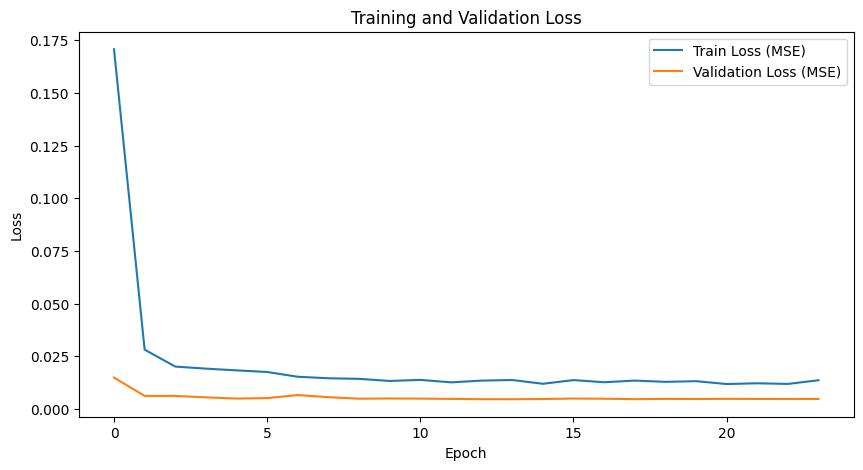

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

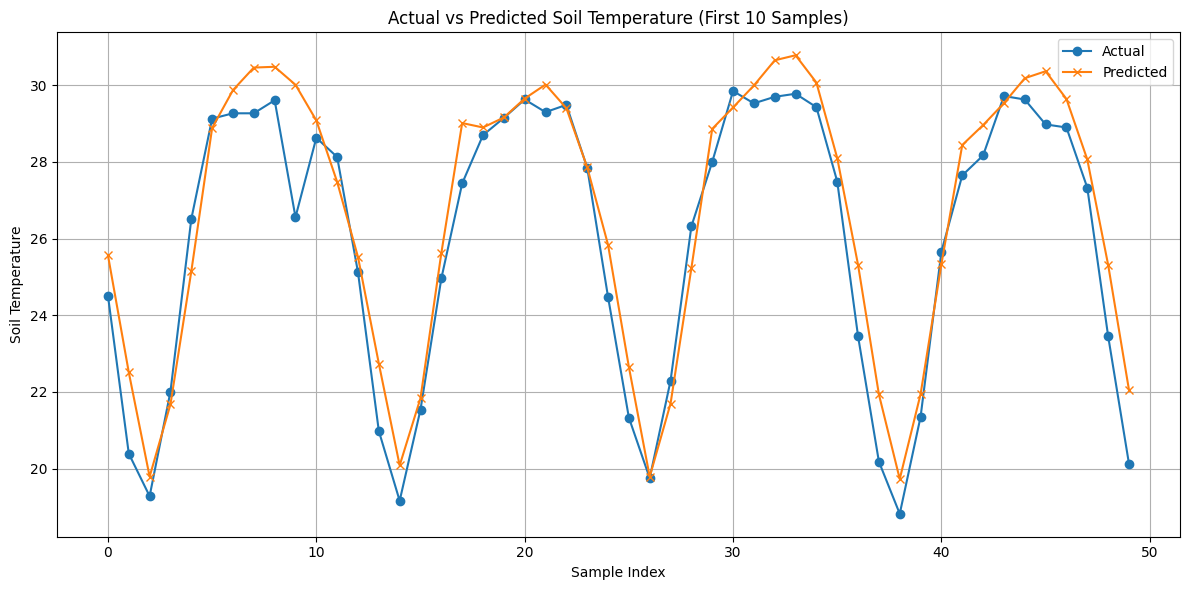

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(comparison['Actual'].values[:50], label='Actual', marker='o')
plt.plot(comparison['Predicted'].values[:50], label='Predicted', marker='x')
plt.title('Actual vs Predicted Soil Temperature (First 10 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Soil Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
